In [1]:
import sys

import torch
import matplotlib.pyplot as plt

import time

import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dsets

import numpy as np
import tqdm

from torch.utils.data import DataLoader
from torch import optim

In [2]:
USE_CUDA = torch.cuda.is_available() # GPU를 사용가능하면 True, 아니라면 False를 리턴
device = torch.device("cuda" if USE_CUDA else "cpu") # GPU 사용 가능하면 사용하고 아니면 CPU 사용
print("다음 기기로 학습합니다:", device)

다음 기기로 학습합니다: cuda


In [3]:
print("epoch와 batch size를 지정해줍니다.")
_epoch = 30
batch_size = 128

epoch와 batch size를 지정해줍니다.


In [4]:
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()
])

In [5]:
print("File Download : CIFAR10 dataset")

train_dataset = dsets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

val_dataset = dsets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

File Download : CIFAR10 dataset


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


1번 모델 : CNN (실습 시간에 사용한 코드 활용)

In [6]:
class my_CNN(nn.Module):
    def __init__(self):
        super(my_CNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) 
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv4 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv5 = nn.Conv2d(64, 64, 3, padding=2)

        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(32)
        self.bn4 = nn.BatchNorm2d(64)
        self.bn5 = nn.BatchNorm2d(64)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64*4*4, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)

        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)

        x = F.relu(self.bn5(self.conv5(x)))

        x = x.view(-1, 64*4*4)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)

        return x

In [7]:
net1 = my_CNN()
net1 = net1.to(device)
criterion = nn.CrossEntropyLoss()

In [8]:
train_loss_history_myCNN = []
val_loss_history_myCNN = []
train_acc_history_myCNN = []
val_acc_history_myCNN = []

In [9]:
lr = 0.1
optimizer = optim.SGD(net1.parameters(), lr=lr, momentum=0.9)
lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[int(_epoch * 0.75), int(_epoch * 0.01)], gamma=0.1, last_epoch=-1)

In [10]:
print("Training Start : First model (my_CNN)")
start = time.time()

for epoch in range(_epoch):  
    lr_scheduler.step()
    
    avg_cost = 0.0
    train_loss = 0.0
    train_total = 0.0


    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = net1(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_loss += loss.item()
        train_total += (torch.argmax(outputs, dim=1) == labels).sum().item()
    
    avg_cost /= batch_size
    train_loss = train_loss / len(train_loader)
    train_acc = train_total / len(train_dataset)
    

    with torch.no_grad():
        val_loss = 0.0
        total = 0
        for val_step, val in enumerate(val_loader):
            val_x, val_label = val
            
            val_x = val_x.to(device)
            val_label = val_label.to(device)

            val_output = net1(val_x)
            v_loss = criterion(val_output, val_label)
            val_loss += v_loss
            total += (torch.argmax(val_output, dim=1) == val_label).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = total / len(val_dataset)

    print("epoch: {}/{} | train loss: {} | val loss: {}".format(epoch+1, _epoch, train_loss , val_loss))
    print("train acc : {}".format(train_acc))
    print("val_acc: {}".format(val_acc))

    train_loss_history_myCNN.append(train_loss)
    train_acc_history_myCNN.append(train_acc)     
    val_loss_history_myCNN .append(val_loss)
    val_acc_history_myCNN.append(val_acc)

end = time.time()

t = int(end - start)
print("Training time: %dm %ds" %(t//60, t%60))
print("Training Finished")

Training Start : First model (my_CNN)


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


epoch: 1/30 | train loss: 3.790963979023497 | val loss: 1.6545897722244263
train acc : 0.26032
val_acc: 0.3547
epoch: 2/30 | train loss: 3.1514003636587002 | val loss: 1.4636013507843018
train acc : 0.39482
val_acc: 0.4417
epoch: 3/30 | train loss: 2.8191263925693835 | val loss: 1.3298776149749756
train acc : 0.47594
val_acc: 0.5152
epoch: 4/30 | train loss: 2.579104366204928 | val loss: 1.2330491542816162
train acc : 0.53678
val_acc: 0.5654
epoch: 5/30 | train loss: 2.3964087063699124 | val loss: 1.1897497177124023
train acc : 0.57914
val_acc: 0.5805
epoch: 6/30 | train loss: 2.2632469356517353 | val loss: 1.1182363033294678
train acc : 0.6061
val_acc: 0.6207
epoch: 7/30 | train loss: 2.14112890345971 | val loss: 1.082331895828247
train acc : 0.63252
val_acc: 0.6284
epoch: 8/30 | train loss: 2.0721473196888214 | val loss: 1.0380117893218994
train acc : 0.64466
val_acc: 0.651
epoch: 9/30 | train loss: 2.0010260282575016 | val loss: 1.0143940448760986
train acc : 0.65966
val_acc: 0.6544

In [11]:
print("Test Start : First model (my_CNN)")

start = time.time()
correct = 0.0
total = 0.0

with torch.no_grad():
    for i, data in enumerate(val_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = net1(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

end = time.time()
t = int(end-start)
print("Test time: %dm %ds" %(t//60, t%60))
print("Test Finished")

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Test Start : First model (my_CNN)
Test time: 0m 2s
Test Finished
Accuracy of the network on the 10000 test images: 75.0 %


Show Loss plot : First model


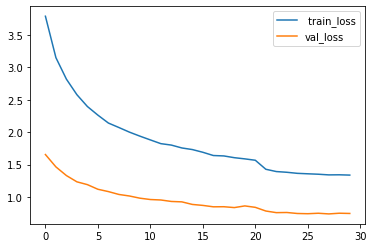

In [12]:
print("Show Loss plot : First model")

plt.plot(train_loss_history_myCNN, label = ' train_loss')
val_loss_history = [i.cpu() for i in val_loss_history_myCNN]
plt.plot(val_loss_history, label = 'val_loss')
plt.legend()
plt.show()

Show Acc plot : First model


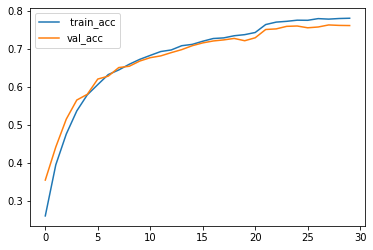

In [13]:
print("Show Acc plot : First model")

plt.plot(train_acc_history_myCNN, label = ' train_acc')
plt.plot(val_acc_history_myCNN, label = 'val_acc')
plt.legend()
plt.show()

2번 모델 : ResNet

In [14]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        if stride != 1:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, 2, 1), 
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.downsample = None
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        if self.downsample is not None:
            x = self.downsample(x)
        out += x
        return F.relu(out)


class ResNet(nn.Module):
    def __init__(self, n):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 16, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = []

        for _ in range(n):
            self.layer1.append(ResidualBlock(16, 16, 1))
        self.layer2 = [ResidualBlock(16, 32, 2)]
        for _ in range(n-1):
            self.layer2.append(ResidualBlock(32, 32, 1))
        self.layer3 = [ResidualBlock(32, 64, 2)]
        for _ in range(n-1):
            self.layer3.append(ResidualBlock(64, 64, 1))
        
        self.layer1 = nn.Sequential(*self.layer1)
        self.layer2 = nn.Sequential(*self.layer2)
        self.layer3 = nn.Sequential(*self.layer3)

        self.pool = nn.AvgPool2d(8)
        self.linear = nn.Linear(64, 10)

    def forward(self, x):
        x = self.bn1(self.conv1(x))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

In [15]:
net2 = ResNet(3)
net2 = net2.to(device)
criterion = nn.CrossEntropyLoss()

In [16]:
train_loss_history_ResNet = []
val_loss_history_ResNet = []
train_acc_history_ResNet = []
val_acc_history_ResNet = []

In [17]:
lr = 0.1
optimizer = optim.SGD(net2.parameters(), lr=lr, momentum=0.9)
lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[int(_epoch * 0.5), int(_epoch * 0.05)], gamma=0.1, last_epoch=-1)

In [18]:
print("Training Start : Second model (ResNet)")
start = time.time()

for epoch in range(_epoch):  
    lr_scheduler.step()
    
    avg_cost = 0.0
    train_loss = 0.0
    train_total = 0.0


    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = net2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_loss += loss.item()
        train_total += (torch.argmax(outputs, dim=1) == labels).sum().item()
    
    avg_cost /= batch_size
    train_loss = train_loss / len(train_loader)
    train_acc = train_total / len(train_dataset)


    with torch.no_grad():
        val_loss = 0.0
        total = 0
        for val_step, val in enumerate(val_loader):
            val_x, val_label = val
            
            val_x = val_x.to(device)
            val_label = val_label.to(device)

            val_output = net2(val_x)
            v_loss = criterion(val_output, val_label)
            val_loss += v_loss
            total += (torch.argmax(val_output, dim=1) == val_label).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = total / len(val_dataset)

    print("epoch: {}/{} | train loss: {} | val loss: {}".format(epoch+1, _epoch, train_loss , val_loss))
    print("train acc : {}".format(train_acc))
    print("val_acc: {}".format(val_acc))

    train_loss_history_ResNet.append(train_loss)
    train_acc_history_ResNet.append(train_acc)     
    val_loss_history_ResNet .append(val_loss)
    val_acc_history_ResNet.append(val_acc)

end = time.time()

t = int(end - start)
print("Training time: %dm %ds" %(t//60, t%60))
print("Training Finished")

Training Start : Second model (ResNet)
epoch: 1/30 | train loss: 3.0266331370224426 | val loss: 1.211851716041565
train acc : 0.43918
val_acc: 0.5581
epoch: 2/30 | train loss: 2.1278432503990503 | val loss: 0.9610251188278198
train acc : 0.61966
val_acc: 0.652
epoch: 3/30 | train loss: 1.7428894299070548 | val loss: 0.8357593417167664
train acc : 0.69226
val_acc: 0.7044
epoch: 4/30 | train loss: 1.4990620808223325 | val loss: 0.7343884706497192
train acc : 0.73692
val_acc: 0.7394
epoch: 5/30 | train loss: 1.3472151315730552 | val loss: 0.6575852036476135
train acc : 0.7644
val_acc: 0.771
epoch: 6/30 | train loss: 1.230382020821047 | val loss: 0.630879819393158
train acc : 0.78596
val_acc: 0.7865
epoch: 7/30 | train loss: 1.1312595125659348 | val loss: 0.5985938310623169
train acc : 0.80366
val_acc: 0.7923
epoch: 8/30 | train loss: 1.0637359327977272 | val loss: 0.5825294256210327
train acc : 0.81576
val_acc: 0.8007
epoch: 9/30 | train loss: 1.0095324961425702 | val loss: 0.550773918628

In [19]:
print("Test Start : Second model (ResNet)")

start = time.time()
correct = 0.0
total = 0.0

with torch.no_grad():
    for i, data in enumerate(val_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = net2(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

end = time.time()
t = int(end-start)
print("Test time: %dm %ds" %(t//60, t%60))
print("Test Finished")

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Test Start : Second model (ResNet)
Test time: 0m 2s
Test Finished
Accuracy of the network on the 10000 test images: 86.0 %


Show Loss plot : Second model


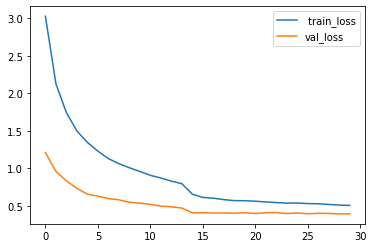

In [20]:
print("Show Loss plot : Second model")

plt.plot(train_loss_history_ResNet, label = ' train_loss')
val_loss_history_ResNet = [i.cpu() for i in val_loss_history_ResNet]
plt.plot(val_loss_history_ResNet, label = 'val_loss')
plt.legend()
plt.show()

Show Acc plot : Second model


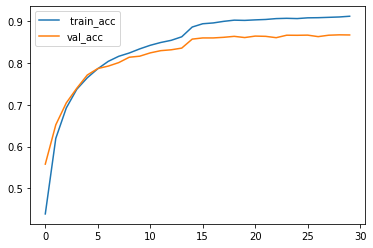

In [21]:
print("Show Acc plot : Second model")

plt.plot(train_acc_history_ResNet, label = ' train_acc')
plt.plot(val_acc_history_ResNet, label = 'val_acc')
plt.legend()
plt.show()

3번 모델 : DenseNet

In [22]:
class Bottleneck(nn.Module):
    def __init__(self, inChannels, growthRate):
        super().__init__()

        innerChannel = 4 * growthRate

        self.bottleNeck = nn.Sequential(
            nn.BatchNorm2d(inChannels),
            nn.ReLU(inplace=True),
            nn.Conv2d(inChannels, innerChannel, kernel_size=1, bias=False),
            nn.BatchNorm2d(innerChannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(innerChannel, growthRate, kernel_size=3, padding=1, bias=False)
        )

    def forward(self, x):
        return torch.cat([x, self.bottleNeck(x)], 1)


class Transition(nn.Module):
    def __init__(self, inChannels, outChannels):
        super().__init__()
        
        self.down_sample = nn.Sequential(
            nn.BatchNorm2d(inChannels),
            nn.Conv2d(inChannels, outChannels, 1, bias=False),
            nn.AvgPool2d(2, stride=2)
        )

    def forward(self, x):
        return self.down_sample(x)


class DenseNet(nn.Module):
    def __init__(self, block, nblocks, growthRate=12, reduction=0.5, numClass=100):
        super().__init__()
        self.growthRate = growthRate

        innerChannels = 2 * growthRate

        self.conv1 = nn.Conv2d(3, innerChannels, kernel_size=3, padding=1, bias=False)

        self.features = nn.Sequential()

        for index in range(len(nblocks) - 1):
            self.features.add_module("dense_block_layer_{}".format(index), self._make_dense_layers(block, innerChannels, nblocks[index]))
            innerChannels += growthRate * nblocks[index]
            outChannels = int(reduction * innerChannels) 
            self.features.add_module("transition_layer_{}".format(index), Transition(innerChannels, outChannels))
            innerChannels = outChannels

        self.features.add_module("dense_block{}".format(len(nblocks) - 1), self._make_dense_layers(block, innerChannels, nblocks[len(nblocks)-1]))
        innerChannels += growthRate * nblocks[len(nblocks) - 1]
        self.features.add_module('bn', nn.BatchNorm2d(innerChannels))
        self.features.add_module('relu', nn.ReLU(inplace=True))

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.linear = nn.Linear(innerChannels, numClass)

    def forward(self, x):
        output = self.conv1(x)
        output = self.features(output)
        output = self.avgpool(output)
        output = output.view(output.size()[0], -1)
        output = self.linear(output)
        return output

    def _make_dense_layers(self, block, inChannels, nblocks):
        denseBlock = nn.Sequential()
        for index in range(nblocks):
            denseBlock.add_module('bottle_neck_layer_{}'.format(index), block(inChannels, self.growthRate))
            inChannels += self.growthRate
        return denseBlock

def densenet():
    return DenseNet(Bottleneck, [6,12,24,16], growthRate=32)

In [23]:
net3 = densenet()
net3 = net3.to(device)
criterion = nn.CrossEntropyLoss()

In [24]:
train_loss_history_DenseNet = []
val_loss_history_DenseNet = []
train_acc_history_DenseNet = []
val_acc_history_DenseNet = []

In [25]:
lr = 0.1
optimizer = optim.SGD(net3.parameters(), lr=lr, momentum=0.9)
lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[int(_epoch * 0.5), int(_epoch * 0.05)], gamma=0.1, last_epoch=-1)

In [26]:
print("Training Start : Third model (DenseNet)")
start = time.time()

for epoch in range(_epoch):  
    lr_scheduler.step()
    
    avg_cost = 0.0
    train_loss = 0.0
    train_total = 0.0


    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = net3(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_loss += loss.item()
        train_total += (torch.argmax(outputs, dim=1) == labels).sum().item()
    
    avg_cost /= batch_size
    train_loss = train_loss / len(train_loader)
    train_acc = train_total / len(train_dataset)


    with torch.no_grad():
        val_loss = 0.0
        total = 0
        for val_step, val in enumerate(val_loader):
            val_x, val_label = val
            
            val_x = val_x.to(device)
            val_label = val_label.to(device)

            val_output = net3(val_x)
            v_loss = criterion(val_output, val_label)
            val_loss += v_loss
            total += (torch.argmax(val_output, dim=1) == val_label).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = total / len(val_dataset)

    print("epoch: {}/{} | train loss: {} | val loss: {}".format(epoch+1, _epoch, train_loss , val_loss))
    print("train acc : {}".format(train_acc))
    print("val_acc: {}".format(val_acc))

    train_loss_history_DenseNet.append(train_loss)
    train_acc_history_DenseNet.append(train_acc)     
    val_loss_history_DenseNet .append(val_loss)
    val_acc_history_DenseNet.append(val_acc)

end = time.time()

t = int(end - start)
print("Training time: %dm %ds" %(t//60, t%60))
print("Training Finished")

Training Start : Third model (DenseNet)
epoch: 1/30 | train loss: 2.7520563556715048 | val loss: 1.0114282369613647
train acc : 0.50942
val_acc: 0.6388
epoch: 2/30 | train loss: 1.702548352348835 | val loss: 0.7619084119796753
train acc : 0.69564
val_acc: 0.7341
epoch: 3/30 | train loss: 1.3011812518929582 | val loss: 0.6076890826225281
train acc : 0.77334
val_acc: 0.7938
epoch: 4/30 | train loss: 1.0676649520769144 | val loss: 0.56734299659729
train acc : 0.81606
val_acc: 0.8067
epoch: 5/30 | train loss: 0.9138812689525088 | val loss: 0.49018388986587524
train acc : 0.84032
val_acc: 0.8368
epoch: 6/30 | train loss: 0.7975310586450045 | val loss: 0.44586724042892456
train acc : 0.86218
val_acc: 0.8482
epoch: 7/30 | train loss: 0.7106834067712964 | val loss: 0.41961684823036194
train acc : 0.877
val_acc: 0.8578
epoch: 8/30 | train loss: 0.635761557332695 | val loss: 0.4221547245979309
train acc : 0.89106
val_acc: 0.8551
epoch: 9/30 | train loss: 0.588958395868921 | val loss: 0.382040649

In [27]:
print("Test Start : Third model (DenseNet)")

start = time.time()
correct = 0.0
total = 0.0

with torch.no_grad():
    for i, data in enumerate(val_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = net3(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

end = time.time()
t = int(end-start)
print("Test time: %dm %ds" %(t//60, t%60))
print("Test Finished")

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Test Start : Third model (DenseNet)
Test time: 0m 10s
Test Finished
Accuracy of the network on the 10000 test images: 91.0 %


Show Loss plot : Third model


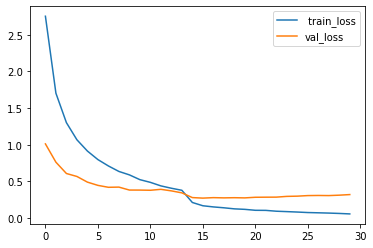

In [28]:
print("Show Loss plot : Third model")

plt.plot(train_loss_history_DenseNet, label = ' train_loss')
val_loss_history_DenseNet = [i.cpu() for i in val_loss_history_DenseNet]
plt.plot(val_loss_history_DenseNet, label = 'val_loss')
plt.legend()
plt.show()

Show Acc plot : Third model


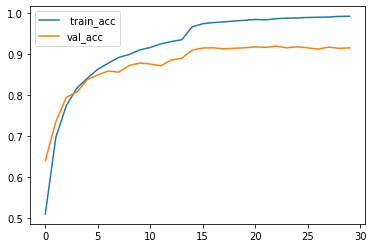

In [29]:
print("Show Acc plot : Third model")

plt.plot(train_acc_history_DenseNet, label = ' train_acc')
plt.plot(val_acc_history_DenseNet, label = 'val_acc')
plt.legend()
plt.show()

In [30]:
print("Train All Models!!!")

Train All Models!!!


Compare : three models val_acc


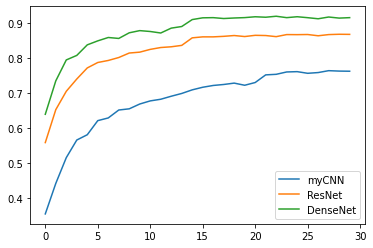

In [31]:
print("Compare : three models val_acc")

plt.plot(val_acc_history_myCNN, label = 'myCNN')
plt.plot(val_acc_history_ResNet, label = 'ResNet')
plt.plot(val_acc_history_DenseNet, label = 'DenseNet')
plt.legend()
plt.show()

Compare : three models val_loss


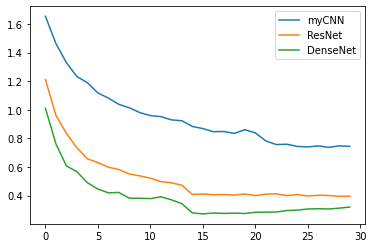

In [32]:
print("Compare : three models val_loss")

val_loss_history_myCNN = [i.cpu() for i in val_loss_history_myCNN]
plt.plot(val_loss_history_myCNN, label = 'myCNN')
val_loss_history_ResNet = [i.cpu() for i in val_loss_history_ResNet]
plt.plot(val_loss_history_ResNet, label = 'ResNet')
val_loss_history_DenseNet = [i.cpu() for i in val_loss_history_DenseNet]
plt.plot(val_loss_history_DenseNet, label = 'DenseNet')
plt.legend()
plt.show()